# Main1 프로젝트 : 한국어 데이터 챗봇 생성
### 데이터 : [한국어 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)
### 모델 : [GPT1](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) 

__비고__ : GPT1을 transformer기반으로 수정 작성 되었음
- 수정, 삭제된 코드 : ~~취소선 표시~~ , # 주석처리
  - ex) : ~~인코더~~ , ~~포지셔널 인코딩~~

### GPT1 VS Transformer
GPT1
- 임베딩 + 포지셔널 임베딩
- 디코더
  - 멀티헤드 어텐션
    - 룩업헤드 마스킹
  - 피드포워드 신경망

Transformer
- 임베딩 + 포지셔널 인코딩
- 인코더
  - 멀티헤드 어텐션
    - 패딩 마스킹
  - 피드포워드 신경망
- 디코더
  - 멀티헤드 어텐션
    - 룩업헤드 마스킹
  - 디코더-인코더 어텐션
    - 패딩 마스킹
  - 피드포워드 신경망

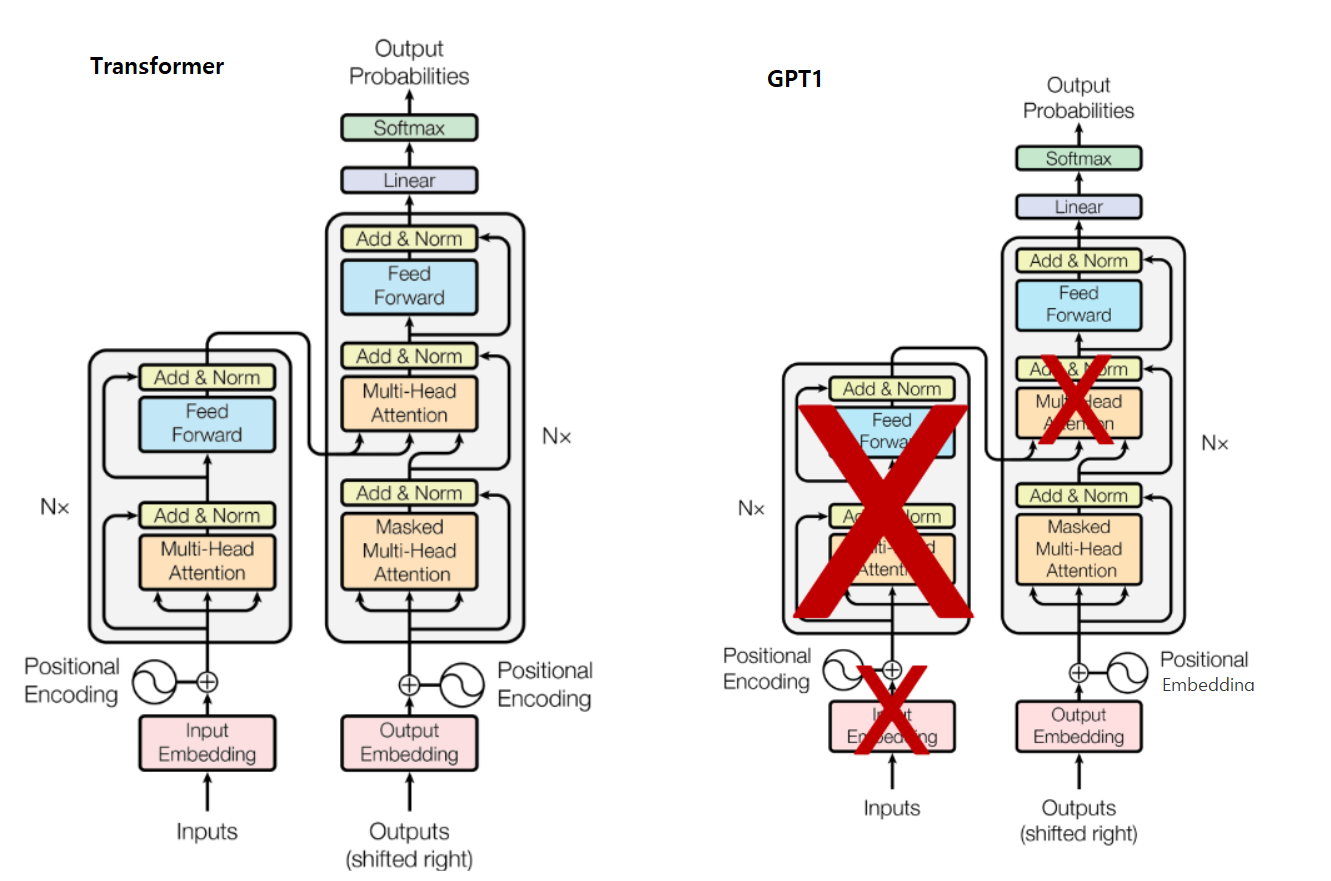

## 0. 라이브러리

In [167]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [168]:
print(tfds.__version__)

4.4.0


## 1. 데이터 수집
- 한국어 데이터
- 변수 : Q, A, label

In [169]:
data = pd.read_csv("C:/Users/lkg/Desktop/vscode\AIFFEL QUEST\Exploration\Quest7/ChatbotData.csv")
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### 1.1 데이터 기본 정보 확인
- 데이터 내 결측치
- 데이터 샘플 갯수

In [170]:
print(data.isnull().sum())
print(len(data))

Q        0
A        0
label    0
dtype: int64
11823


## 2. 데이터 전처리
### 2.1 샘플의 최대 갯수 설정
- 데이터가 많지 않으므로 모두 사용

In [171]:
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


### 2.2 전처리 함수 정의
- 일부 영어 데이터의 소문자화
  - ex): SNS -> sns, SD -> sd
- 양쪽 공백 제거
  - 일관성 확보
- 구두점 사이 거리
  - 단어 구분, 토큰화 용이성
- 예외 문자 처리
  - 공백으로 대체 - [참고](https://signing.tistory.com/74)

In [172]:
# 전처리 함수 정의
def preprocess_sentence(sentence):
  # 소문자화, 양쪽 공백 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점 사이의 거리
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 예외 문자를 공백으로 대체
  sentence = re.sub(r"[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

### 2.3 데이터 전처리 함수 적용
- 질문,답변 데이터 전처리
  - `tpdm()` : 진행률 표시
  - 전처리 함수에 적용 후 각각 `questions`, `answers`에 append

In [173]:
# 질문 데이터 전처리
questions = []

for sentence in tqdm(data['Q'], desc="데이터셋의 Q 컬럼 전처리 중..."):
    questions.append(preprocess_sentence(sentence))

# 답변 데이터 전처리
answers = []

for sentence in tqdm(data['A'], desc="데이터셋의 A 컬럼 전처리 중..."):
    answers.append(preprocess_sentence(sentence))

# 전처리 확인
print("Q 데이터 5개: {0}".format(questions[:5]))
print("A 데이터 5개: {0}".format(answers[:5]))

데이터셋의 A 컬럼 전처리 중...: 100%|██████████| 11823/11823 [00:00<00:00, 134352.18it/s]

Q 데이터 5개: ['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네']
A 데이터 5개: ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## 3. SubwordTextEncoder
- 내부 토크나이저

## 3.1 단어장 생성
- SubwordTextEncoder로 단어 집합 생성
- 질문+답변 데이터 사용

In [174]:
# SubwordTextEncoder 단어장
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

### 3.1.1 시작 토큰, 종료 토큰
- 모델에게 입력 시퀀스의 시작을 나타내는 시작 토큰과 
- 종료 시퀀스의 끝을 나타내는 종료 토큰 정수 할당
  - 인덱스가 겹치지 않도록 설정 [단어장 끝], [끝+1]
  - 단어장 크기 : tokenizer + 2(시작, 종료)

In [175]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

# 토큰의 번호와 단어 집합의 크기 확인
print("시작 토큰 번호 : {0}".format(START_TOKEN))
print("종료 토큰 번호 : {0}".format(END_TOKEN))
print("단어 집합의 크기 : {0}".format(VOCAB_SIZE))

시작 토큰 번호 : [8162]
종료 토큰 번호 : [8163]
단어 집합의 크기 : 8164


### 3.1.2 샘플의 최대 허용 길이 설정
- 샘플의 최대 허용 길이를 설정 = 패딩 후의 최종 길이
  - 질문과 답변의 분포를 확인하여 적절한 값 설정
  - ex): (최소,  최대,  평균 길이)

In [176]:
# 질문, 답변의 분포
Q_len = [len(s.split()) for s in data['Q']]
A_len = [len(s.split()) for s in data['A']]

print('질문의 최소 길이 : {}'.format(np.min(Q_len)))
print('질문의 최대 길이 : {}'.format(np.max(Q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(Q_len)))

print('\n답변의 최소 길이 : {}'.format(np.min(A_len)))
print('답변의 최대 길이 : {}'.format(np.max(A_len)))
print('답변의 평균 길이 : {}'.format(np.mean(A_len)))

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.587414361837097

답변의 최소 길이 : 1
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6936479742874058


In [177]:
# 샘플의 최대 허용 길이 설정
MAX_LENGTH = 20
print('샘플의 최대 허용 길이 : {}'.format(MAX_LENGTH))

샘플의 최대 허용 길이 : 20


## 3.2 인코딩, 패딩
- 각 단어를 고유한 정수로 인코딩(Inter encoding), 패딩(Padding)
### 3.2.1 토큰화, 필터 함수 정의
- 각 입력 (sentence1,sentence2) 토큰화
  - 추가 : `START_TOKEN`, `END_TOKEN` 토큰
- 길이 필터링
  - MAX_LENGTH 보다 짧은 경우만 데이터 셋으로 허용
- 패딩
  - 문장의 앞쪽(`pre`)에 '0' 추가
  - 데이터가 동일한 차원을 가짐

In [178]:
# 훈련 데이터셋 (질문, 답변)을 입력 -> 토큰화, 필터 함수
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='pre')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='pre')
  
  return tokenized_inputs, tokenized_outputs

### 3.2.2 단어장 크기, 샘플 개수 확인

In [179]:
# 단어장 크기와 샘플의 개수 확인
questions, answers = tokenize_and_filter(questions, answers)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8164
필터링 후의 질문 샘플 개수: 11792
필터링 후의 답변 샘플 개수: 11792


## 3.3 교사 강요 사용
- Teacher Forcing
  - 디코더의 입력과 실제값(레이블)을 정의 - [위키독스: RNN 언어모델](https://wikidocs.net/46496)
  - 자기회귀 모델(auto-regressive model, AR) : 
    - 이전 자신의 출력이 현재 자신의 상태를 결정하는 모델
- `tf.data.Dataset` API :
  - 훈련 프로세스의 속도가 빨라지도록 입력 파이프 라인 구축

### 3.3.1 교사 강요
- tf.data.Dataset API의 입력 : 질문과 답변의 쌍
- 디코더는 이전의 target을 다음의 input으로 사용
  - 디코더의 입력값 : answers[:, :-1] : 마지막 토큰을 제외한 데이터를 사용
  - 디코더의 레이블 : answers[:, 1:] : 첫 번째 토큰을 제외한 나머지 부분을 사용

In [180]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000


dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 4. 모델 구성
- ~~인코더~~
  - ~~0 임베딩 레이어 + 포지셔널 인코딩 레이어~~
  - ~~1 멀티 헤드 어텐션 (셀프 어텐션)~~
    - ~~스케일드 닷 프로덕트 어텐션~~
    - ~~패딩 마스크~~
  - ~~2 피드포워드 신경망~~
    - ~~완전 연결 층~~
- 디코더
  - 0 임베딩 레이어 + ~~포지셔널 인코딩 레이어~~ 포지셔널 임베딩 레이어
  - 1 멀티 헤드 어텐션 (셀프 어텐션)
    - 스케일드 닷 프로덕트 어텐션
    - 룩 어헤드 마스크
  - ~~2 멀티 헤드 어텐션 (인코더-디코더 어텐션)~~
    - ~~패딩 마스크~~
  - 3 피드포워드 신경망
    - 완전 연결 층
- -> GPT1
  - 디코더

### 4.1.1 포지셔널 임베딩 레이어 (~~포지셔널 인코딩 레이어~~)
- 포지셔널 임베딩 레이어
  - 단어의 위치 정보를 벡터로 표현
- ~~포지셔널 인코딩 레이어~~
  - ~~단어의 순서 정보를 벡터로 표현~~

In [181]:
# 포지셔널 임베딩 레이어
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, maxlen, d_model):
    super(PositionalEmbedding, self).__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=d_model)

  def call(self, inputs):
    position_indices = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
    position_indices = position_indices[tf.newaxis, :]
    
    pos_embedding = self.pos_embedding(position_indices)
    
    return inputs + pos_embedding

### 4.1.2 스케일드 닷 프로덕트 어텐션
- 스케일드 닷 프로덕트 어텐션

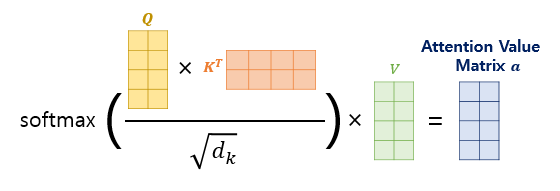
- 벡터의 유사도를 0과 1사이로 Normalize
  - 연산의 결과가 입력 벡터의 차원 수에 따라 크기가 매우 커짐 방지
  - softmax의 출력값이 작아지는 것을 방지
    - softmax의 출력값이 작아지면 역전파 과정에서 기울기 소실 문제가 발생

In [182]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 4.1.3 멀티-헤드 어텐션
- 멀티-헤드 어텐션

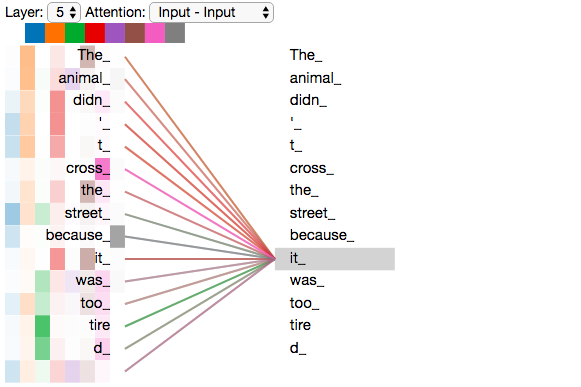
- 어텐션을 병렬로 수행
  - 각 어텐션이 서로 다른 셀프 어텐션 결과를 가져옴
  - 서로 다른 관점에서 정보를 놓침을 방지

In [183]:
# 멀티-헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  # 병렬 연산을 위한 입력 벡터의 헤드 수를 설정하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 생성
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결 (concatenate)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에 Dense를 한 번 더 적용
    outputs = self.dense(concat_attention)

    return outputs

## 4.2 마스킹
- 마스킹 :
  - 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법
- ex): 패딩 마스킹, 룩 어헤드 마스킹

### 4.2.1 ~~패딩 마스킹~~
- ~~transformer(인코더, 디코더(인코더-디코더 어텐션))~~

### 4.2.2 룩 어헤드 마스킹

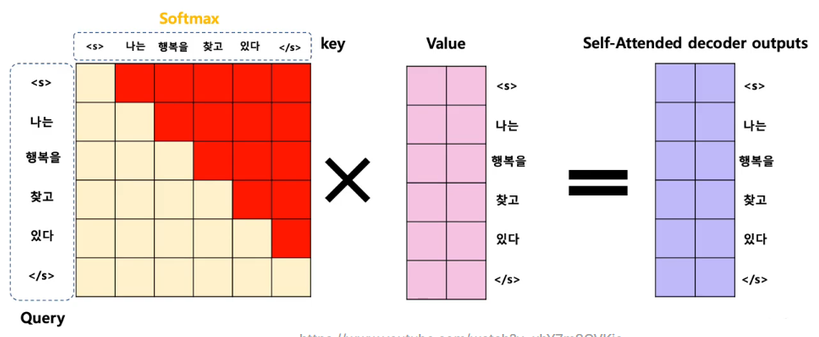
- 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있음
  - 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음
  - 목표 : 이전 단어들로부터 다음 단어를 예측하는 훈련
  - => Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹

- `def create_look_ahead_mask(x):`
  -   ~~seq_len = tf.shape(x)[1]~~
  -   `look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((x, x)), -1, 0)`
  -   ~~padding_mask = create_padding_mask(x)~~
  -   `return look_ahead_mask`
- `class LookAheadMask(tf.keras.layers.Layer):`
  -   `def call(self, inputs):`
      -   `size = tf.shape(inputs)[1]`
      -   `mask = create_look_ahead_mask(size)`
      -   `mask = mask[tf.newaxis, tf.newaxis, :, :]`
      -   `return mask`

In [184]:
# 록어헤드 마스킹 기능을 가지는 함수 선언
def create_look_ahead_mask(x):
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((x, x)), -1, 0)
  return look_ahead_mask

In [185]:
# 배치 및 헤드 차원 추가
class LookAheadMask(tf.keras.layers.Layer):
    def call(self, inputs):
        size = tf.shape(inputs)[1]
        mask = create_look_ahead_mask(size)
        mask = mask[tf.newaxis, tf.newaxis,:,:]
        return mask

## 4.4 GPT1 디코더 설계 (decoder layer part)
- 디코더 하나의 레이어를 함수로 구현
- 하나의 레이어 안에는 ~~세~~두 개의 서브 레이어가 존재
  - 셀프 어텐션, 피드 포워드 신경망, ~~인코더-디코더 어텐션~~
  
- ~~인코더-디코더 어텐션~~
  - ~~Query는 디코더의 현재 시점에서의 출력에서 생성~~
  - ~~Key와 Value는 인코더의 출력에서 생성~~
    - ~~디코더가 인코더의 정보를 활용할 수 있음~~


### 4.4.1 디코더 하나의 레이어 함수 정의

In [186]:
# 디코더 하나의 레이어를 함수로 구현.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  #################### 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션) ####################
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  # 어텐션 결과를 LayerNormalization
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)


#   #################### 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션) ####################
#   attention2 = MultiHeadAttention(
#       d_model, num_heads, name="attention_2")(inputs={
#           'query': attention1,
#           'key': enc_outputs,
#           'value': enc_outputs,
#           'mask': padding_mask
#       })

#   # 어텐션 결과를 Dropout과 LayerNormalization
#   attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
#   attention2 = tf.keras.layers.LayerNormalization(
#       epsilon=1e-6)(attention2 + attention1)


  ##################### 세 번째 서브 레이어 : 2개의 완전연결층 (피드 포워드 신경망) ####################
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과를 Dropout과 LayerNormalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

#   return tf.keras.Model(
#       inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
#       outputs=outputs,
#       name=name)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

### 4.4.2 디코더 만들기
- 임베딩 층(Embedding layer) 과 ~~포지셔널 인코딩(Positional Encoding)~~ 포지셔널 임베딩을 연결
- 디코더 층을 쌓아 원하는 만큼 반복
  - 파라미터 : num_layers 
- 파라미터 +maxlen

In [187]:
# 디코더 함수 선언 (+maxlen)
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            maxlen,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
#   enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = LookAheadMask()(inputs)
  # 패딩 마스크
#   padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 임베딩
  embeddings = PositionalEmbedding(maxlen, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs,look_ahead_mask],
      outputs=outputs,
      name=name)

### 4.5 GPT1 함수를 정의
- ~~인코더 함수,~~ 디코더 함수를 사용
- ~~enc_padding_mask : 코더에서 패딩을 위한 마스크~~
- look_ahead_mask : 디코더에서 미래의 토큰을 마스크
  - 내부적으로 패딩 마스크도 포함되어 있음
- ~~dec_padding_mask : 인코더-디코더 어텐션에서 인코더의 벡터들을 마스킹~~
- ~~encoder : 인코더~~
- decoder : 디코더
- outputs : 완전 연결 층
- input : ~~[inputs, dec_inputs]~~ dec_inputs

In [188]:
# GPT1 함수를 정의 (+maxlen)
def GPT1(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                maxlen,
                name="GPT1"):
  # inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

#   # 인코더에서 패딩을 위한 마스크
#   enc_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크
  look_ahead_mask = LookAheadMask()(dec_inputs)

#   # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
#   # 디코더에서 패딩을 위한 마스크
#   dec_padding_mask = tf.keras.layers.Lambda(
#       create_padding_mask, output_shape=(1, 1, None),
#       name='dec_padding_mask')(inputs)

#   # 인코더
#   enc_outputs = encoder(
#       vocab_size=vocab_size,
#       num_layers=num_layers,
#       units=units,
#       d_model=d_model,
#       num_heads=num_heads,
#       dropout=dropout,
#   )(inputs=[inputs, enc_padding_mask])

  # 디코더 (+maxlen)
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      maxlen = maxlen
  )(inputs=[dec_inputs, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)

## 4.6 모델 생성
- GPT1( )
- 하이퍼 파라미터 :
  - num_layers : ~~인코더와~~ 디코더의 층의 개수
  - D_MODEL : ~~인코더와~~ 디코더 내부의 입,출력의 고정 차원
  - UNITS : 피드 포워드 신경망의 은닉층의 크기
  - NUM_HEADS : 멀티 헤드 어텐션에서의 헤드 수 
  - DROPOUT : 드롭아웃의 비율

### 4.6.1 모델 생성

In [189]:
# 모델 생성
tf.keras.backend.clear_session()

NUM_LAYERS = 2 
D_MODEL = 256 
NUM_HEADS = 8 
UNITS = 512 
DROPOUT = 0.1 

model = GPT1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    maxlen=MAX_LENGTH)

model.summary()

Model: "GPT1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 look_ahead_mask (LookAheadMask  (1, 1, None, None)  0           ['dec_inputs[0][0]']             
 )                                                                                                
                                                                                                  
 decoder (Functional)           (None, None, 256)    3149312     ['dec_inputs[0][0]',             
                                                                  'look_ahead_mask[0][0]']        
                                                                                               

### 4.6.2 손실 함수 정의

In [190]:
# 손실함수 선언
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 4.6.3 커스텀 학습률
- 커스텀 학습률 : 
  - 모델학습 초기에 learning rate를 급격히 높였다가
  - rain step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 함

In [191]:
# 커스텀 학습률 스케줄러 적용 adam optimizer 클래스를 선언
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

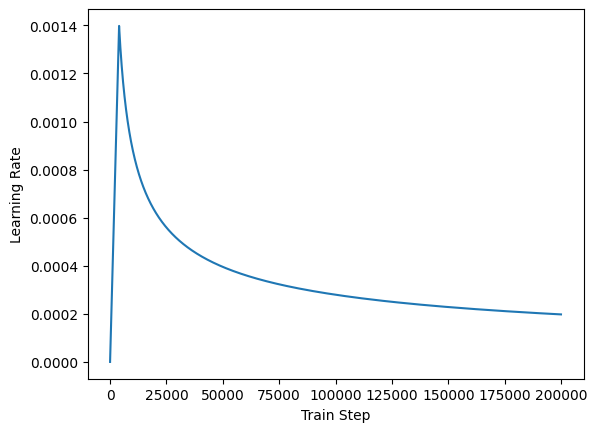

In [192]:
# 커스텀 학습률 스케줄링 계획을 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 4.6.4 모델 컴파일
- 손실 함수와 커스텀 된 학습률(learning rate)을 사용

In [193]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4.6.5 모델 훈련
- epochs = 반복횟수

In [194]:
# 모델 학습 진행
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20


c:\Users\lkg\Desktop\vscode\myenv\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['inputs'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


185/185 [==============================] - 7s 26ms/step - loss: 3.3741 - accuracy: 0.0914
Epoch 2/20
185/185 [==============================] - 4s 24ms/step - loss: 2.5595 - accuracy: 0.1545
Epoch 3/20
185/185 [==============================] - 4s 24ms/step - loss: 2.0185 - accuracy: 0.1588
Epoch 4/20
185/185 [==============================] - 4s 23ms/step - loss: 1.8211 - accuracy: 0.1689
Epoch 5/20
185/185 [==============================] - 5s 25ms/step - loss: 1.6734 - accuracy: 0.1789
Epoch 6/20
185/185 [==============================] - 4s 24ms/step - loss: 1.5254 - accuracy: 0.1924
Epoch 7/20
185/185 [==============================] - 5s 25ms/step - loss: 1.3788 - accuracy: 0.2086
Epoch 8/20
185/185 [==============================] - 5s 24ms/step - loss: 1.2349 - accuracy: 0.2235
Epoch 9/20
185/185 [==============================] - 5s 25ms/step - loss: 1.0994 - accuracy: 0.2360
Epoch 10/20
185/185 [==============================] - 4s 24ms/step - loss: 0.9777 - accuracy: 0.2484


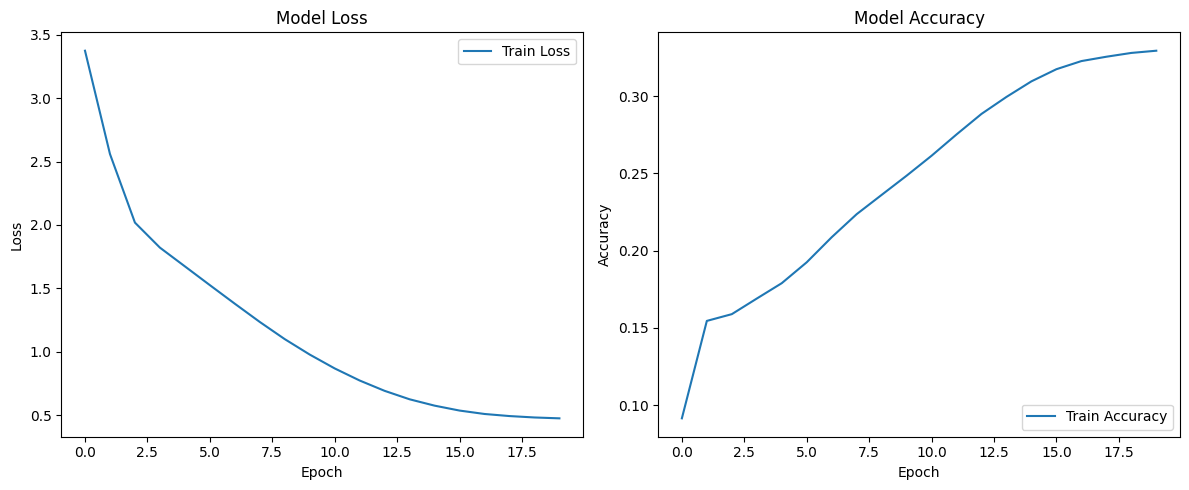

In [195]:
# 전체 그래프 크기 설정
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 위치
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# 정확도 그래프
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 위치
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# 전체 그래프
plt.tight_layout() 
plt.show()

## 5. 모델 평가
### 5.1 디코더 추론 단계
- `decoder_inference()`
1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.
- model input : ~~[sentence, output_sequence]~~ output_sequence

In [196]:
# 위에서 설명한 예측 과정을 수행하는 함수 선언
def decoder_inference(sentence):
  # 1. 문장 전처리
  sentence = preprocess_sentence(sentence)

  # 2. 정수 인코딩과 토큰 추가
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 3. 디코더 출력 시퀀스 초기화
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 4. 디코더 예측 반복
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
    predictions = model(output_sequence, training=False)
    predictions = predictions[:, -1:, :]
    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break
    # 5. 예측된 토큰의 추가
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  # 6. 결과 반환
  return tf.squeeze(output_sequence, axis=0)

### 5.2 챗봇의 대답을 획득
- `decoder_inference()` 에 임의의 문장을 입력
- `sentence_generation()` 로 챗봇 대답 획득

In [197]:
# 함수 정의
# 임의의 문장을 입력하면 decoder_inference()로 챗봇의 대답을 획득
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [199]:
sentence_kr = '너는 정말 멋져 '

epochs_n = sentence_generation(sentence_kr)

입력 : 너는 정말 멋져 
출력 : 내가 원하는 것보다 다른 사람이 원하는 것을 더 우선순위에 두넌 것이에요 . 울라프


## 중간 결과물
### 1. model.summary
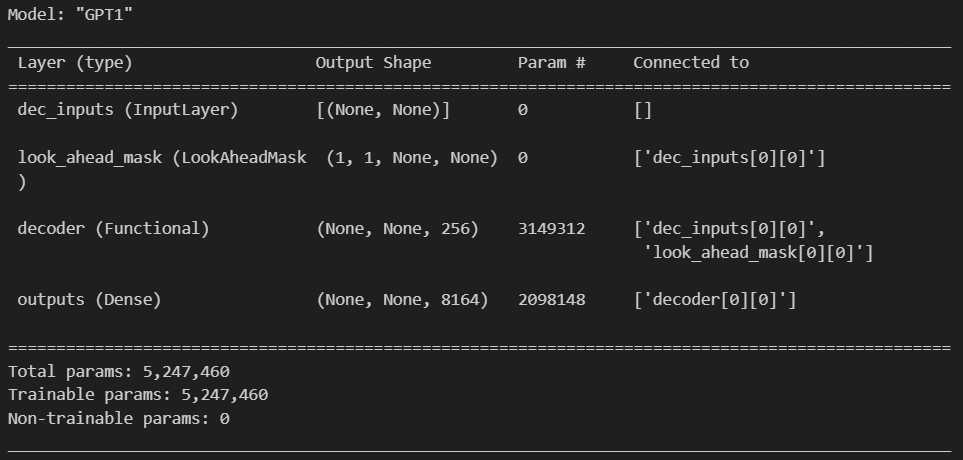

### 2. model.fit
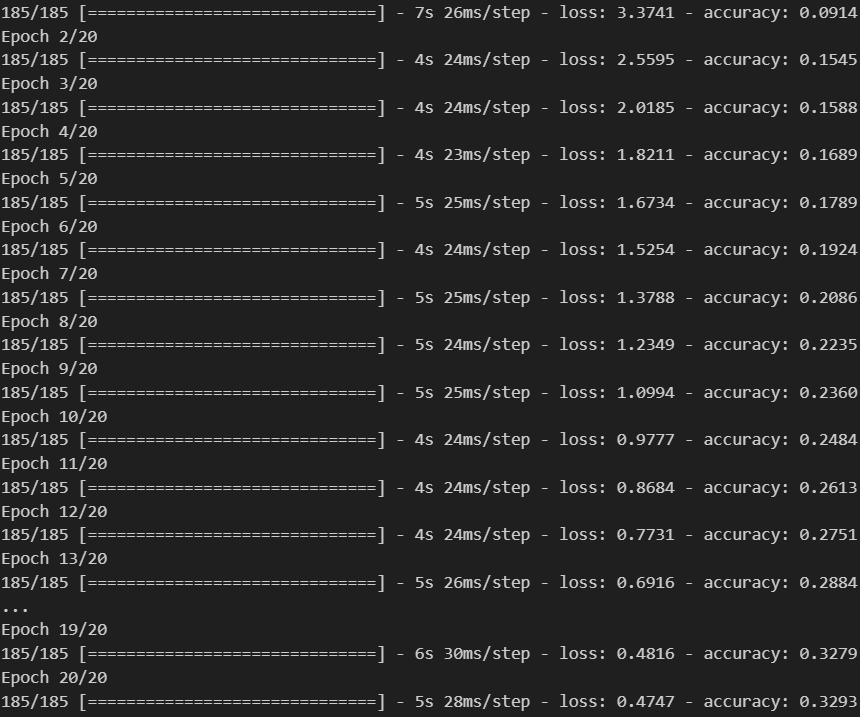

### 3. history 시각화
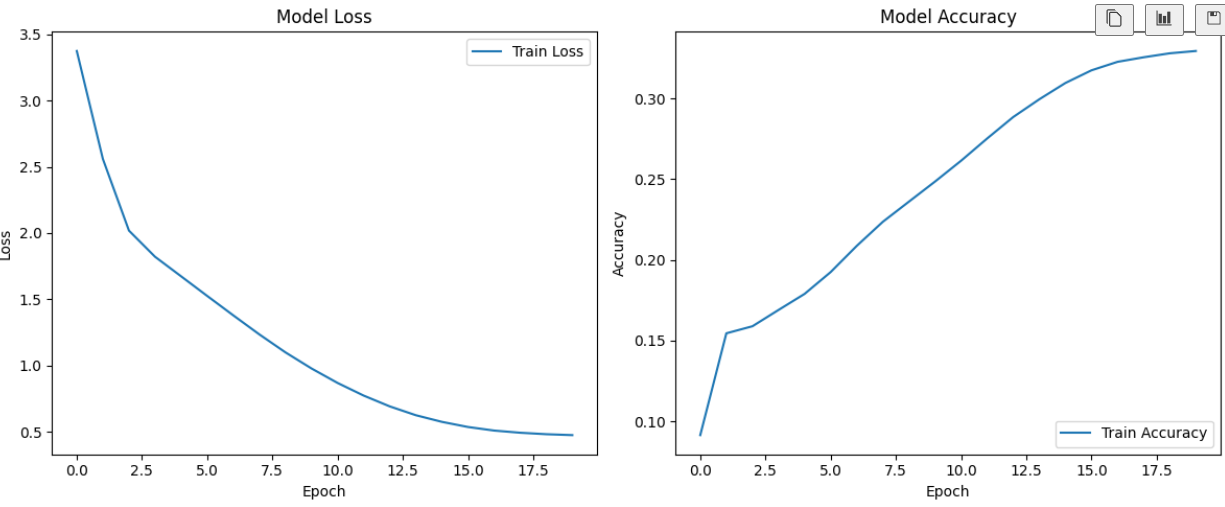

### 회고
- 배운점: gpt의 수행방법과 transformer과의 인코더, 디코더의 차이에 대해 알 수 있었다.
- 아쉬운점: 결과가 만족스럽지 못했다.
- 느낀점: 두 모델의 차이점이 생각보다 단순해 보였지만, 생각만큼 단순하진 않았다.
- 어려웠던점: transformer에서 gpt로 수정할때 입력값과 출력값에 수정이 어려웠다.